Use the below model for **1 (a) - (c)**

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Training and evaluating MNIST task


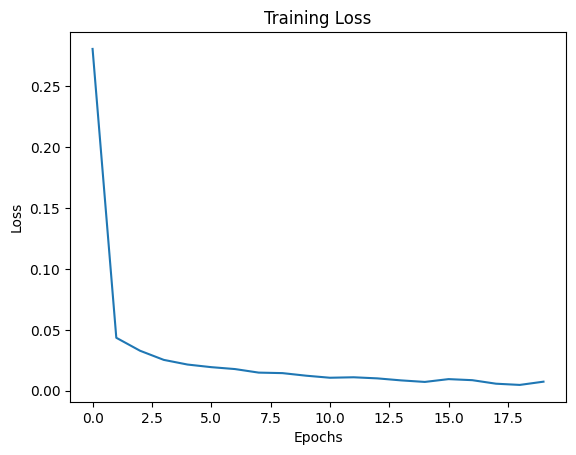

Test accuracy for MNIST task: 99.27%

Training and evaluating SVHN task


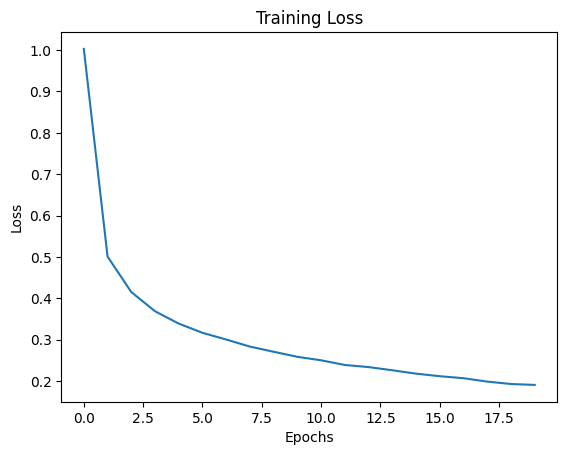

Test accuracy for SVHN task: 92.96%



In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

feature_model = nn.Sequential(nn.Conv2d(1, 32, 5), nn.BatchNorm2d(32), nn.ReLU(), 
                      nn.MaxPool2d(2, stride=2),
                      nn.Conv2d(32, 64, 5), nn.BatchNorm2d(64), nn.ReLU(),
                      nn.Conv2d(64, 64, 3), nn.BatchNorm2d(64), nn.ReLU(),
                      nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

# For (b)-(c) add the task heads on top of the feature_model
# Note this model can adapt the averaging to the size so inputs of 32x32 and 28x28 both work
# Grayscale conversion for SVHN, you may use transforms.Grayscale(num_output_channels=1) found in torchvision
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

# Loading MNIST dataset
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Loading SVHN dataset
svhn_train = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
svhn_test = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# Dataloaders
batch_size = 128
mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
svhn_train_loader = DataLoader(svhn_train, batch_size=batch_size, shuffle=True)
svhn_test_loader = DataLoader(svhn_test, batch_size=batch_size, shuffle=False)

class TaskHead(nn.Module):
    def __init__(self):
        super(TaskHead, self).__init__()
        self.fc1 = nn.Linear(64, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class MultiTaskModel(nn.Module):
    def __init__(self, feature_model):
        super(MultiTaskModel, self).__init__()
        self.feature_model = feature_model
        self.mnist_head = TaskHead()
        self.svhn_head = TaskHead()

    def forward(self, x, task):
        x = self.feature_model(x)
        if task == 'mnist':
            x = self.mnist_head(x)
        elif task == 'svhn':
            x = self.svhn_head(x)
        return x
    
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def plot_training_curves(losses):
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()
    
def train_and_evaluate_individual_tasks(feature_model, device):
    tasks = ['mnist', 'svhn']
    train_loaders = [mnist_train_loader, svhn_train_loader]
    test_loaders = [mnist_test_loader, svhn_test_loader]
    for task, train_loader, test_loader in zip(tasks, train_loaders, test_loaders):
        print(f'Training and evaluating {task.upper()} task')
        model = nn.Sequential(feature_model, TaskHead()).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        losses = []
        for epoch in range(20):
            loss = train(model, train_loader, optimizer, criterion, device)
            losses.append(loss)

        plot_training_curves(losses)
        accuracy = evaluate(model, test_loader, device)
        print(f'Test accuracy for {task.upper()} task: {accuracy:.2f}%\n')
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_and_evaluate_individual_tasks(feature_model, device)

Training and evaluating multi-task model


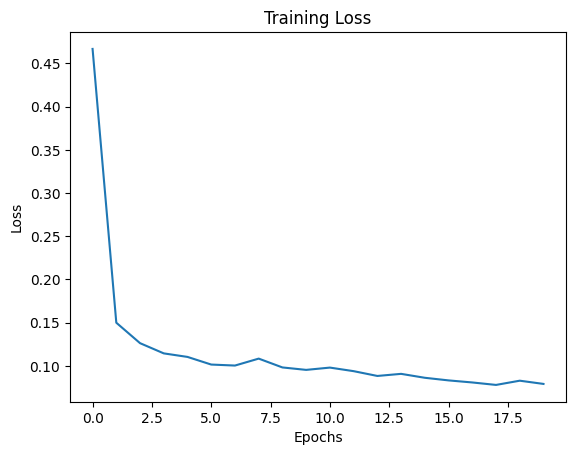

Test accuracy for multi-task model - MNIST: 98.88%
Test accuracy for multi-task model - SVHN: 92.42%


In [12]:
def evaluate_for_multi_task(model, test_loader, device, dataset):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs, dataset)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def train_and_evaluate_multi_task(feature_model, device):
    print('Training and evaluating multi-task model')
    model = MultiTaskModel(feature_model).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    losses = []
    for epoch in range(20):
        running_loss = 0.0
        mnist_iterator = iter(mnist_train_loader)
        svhn_iterator = iter(svhn_train_loader)
        for i in range(len(mnist_train) // batch_size):
#             print(i)
            mnist_inputs, mnist_labels = next(mnist_iterator)
            svhn_inputs, svhn_labels = next(svhn_iterator)
            mnist_inputs, mnist_labels = mnist_inputs.to(device), mnist_labels.to(device)
            svhn_inputs, svhn_labels = svhn_inputs.to(device), svhn_labels.to(device)

            optimizer.zero_grad()
            mnist_outputs = model(mnist_inputs, 'mnist')
            svhn_outputs = model(svhn_inputs, 'svhn')

            loss = criterion(mnist_outputs, mnist_labels) + criterion(svhn_outputs, svhn_labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        losses.append(running_loss / (len(mnist_train) // batch_size))

    plot_training_curves(losses)

    mnist_accuracy = evaluate_for_multi_task(model, mnist_test_loader, device, 'mnist')
    svhn_accuracy = evaluate_for_multi_task(model, svhn_test_loader, device, 'svhn')
    print(f'Test accuracy for multi-task model - MNIST: {mnist_accuracy:.2f}%')
    print(f'Test accuracy for multi-task model - SVHN: {svhn_accuracy:.2f}%')

train_and_evaluate_multi_task(feature_model, device)

***Question*** **1 (d)**

In this question we will train a joint embedding between a model embedding from MNIST and a model embedding from SVHN dataset, both digit datasets. Your specific task to evaluate this will be to try to obtain $70\%$ or higher accuracy on the MNIST classification by embedding MNIST test digits and then searching for the 1-nearest neighbor SVHN digit and using it's category to classify.  

First we will define the mnist and svhn models. For svhn we will use a pre-trained model that can already classify svhn digits. The models are defined below 

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## MNIST model
model_mnist = nn.Sequential(nn.Conv2d(1, 32, 5), nn.BatchNorm2d(32), nn.ReLU(), #For (e) use SVHN nn.Conv2d(3,32,5)
                      nn.MaxPool2d(2, stride=2),
                      nn.Conv2d(32, 64, 5), nn.BatchNorm2d(64), nn.ReLU(),
                      nn.Conv2d(64, 64, 3), nn.BatchNorm2d(64), nn.ReLU(),
                      nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

from torch.utils import model_zoo
from collections import OrderedDict
### SVHN model, we will download one that is already trained to clasify svhn digits
model_urls = {
    'svhn': 'http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/svhn-f564f3d8.pth',
}

class SVHN(nn.Module):
    def __init__(self, features, n_channel, num_classes):
        super(SVHN, self).__init__()
        assert isinstance(features, nn.Sequential), type(features)
        self.features = features

        #We won't use this classifier
        self.classifier = nn.Sequential(
            nn.Linear(n_channel, num_classes)
        )
        print(self.features)
        print(self.classifier)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for i, v in enumerate(cfg):
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            padding = v[1] if isinstance(v, tuple) else 1
            out_channels = v[0] if isinstance(v, tuple) else v
            conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(out_channels, affine=False), nn.ReLU(), nn.Dropout(0.3)]
            else:
                layers += [conv2d, nn.ReLU(), nn.Dropout(0.3)]
            in_channels = out_channels
    return nn.Sequential(*layers)

def svhn_model(n_channel, pretrained=None):
    cfg = [n_channel, n_channel, 'M', 2*n_channel, 2*n_channel, 'M', 4*n_channel, 4*n_channel, 'M', (8*n_channel, 0), 'M']
    layers = make_layers(cfg, batch_norm=True)
    model = SVHN(layers, n_channel=8*n_channel, num_classes=10)
    if pretrained is not None:
        m = model_zoo.load_url(model_urls['svhn'])
        state_dict = m.state_dict() if isinstance(m, nn.Module) else m
        assert isinstance(state_dict, (dict, OrderedDict)), type(state_dict)
        model.load_state_dict(state_dict)

    return model


base_svhn = svhn_model(n_channel=32,pretrained=True).features
svhn_to_joint = nn.Linear(256,64)

model_svhn = nn.Sequential(base_svhn, nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), svhn_to_joint)


#Transformation for SVHN data, you need to use this normalization for the pre-trained model to work properly 
transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ])

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.3, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.3, inplace=False)
  (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (15): ReLU()
  (16): Dropout(p=0.3, inplace=False)
  (17): MaxPool2d(kernel_size=2, stride=2, padding=0

Let's denote model_mnist above as $f_{\theta}(x)$, the pre_trained model $g_{\gamma}$ and svhn_to_joint as the matrix $W$. Finally model_svhn corresponds to $WAg_{\gamma}(x)$. Here A (nn.AdaptiveAvgPool2d) is the averaging operator and has no parameters. Thus model_svhn will map svhn digits to a joint space and model_mnist will map MNIST digits to the joint space.  We will keep $g_{
\gamma}$ fixed and update $\theta, W$.  You should optimize the following objective that is a sum of two loss functions over triplets


$$\min_{\theta, W} \sum_{x_a,x_p,x_n \in \textbf{M}} max(0, \|f_{\theta}(x_a) - WAg_{\gamma}(x_p) \|-\|f_{\theta}(x_a) - WAg_{\gamma}(x_n) \|+\alpha) +\sum_{x_a,x_p,x_n \in \textbf{S}} max(0, \|f_{\theta}(x_p) - WAg_{\gamma}(x_a) \|-\|f_{\theta}(x_n) - WAg_{\gamma}(x_a) \|+\alpha)$$ 


Here $\textbf{M}$ is the set of triplets with anchors from MNIST data, positives from SVHN (matching the anchor class), and negatives from SVHN (with different class from anchors). Similarly $\textbf{S}$ is the set of triplets with anchors from SVHN data, positives from MNIST (matching anchor class), and negatives from MNIST not matching anchor class. You can use nn.TripletMarginLoss to implement this.  

During training with a stochastic optimizer we will sample subsets of $M$ and $S$ for each gradient update, there are various valid ways to sample this as will be discussed.

Note we only optimize W and $\theta$, below see an example how to build the optimizer. Note we want to freeze the $g_{\gamma}$ model so we will also need to disable the dropout and batchnorm. 

In [2]:
optimizer = optim.Adam(list(model_mnist.parameters()) + list(svhn_to_joint.parameters()), lr=1e-5) # you may experiment with different learning rates
model_svhn.eval() #IMPORTANT: BEFORE running set to eval even for training to avoid dropout, we want to keep this fixed except the final layer, otherwise training will need to be much longer


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.3, inplace=False)
    (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (15): ReLU()
    (16): Dropout(p=0.3, inplace=False)

**Suggested settings:** learning rate 1e-5 with Adam, margin ($\alpha$) of 0.2, batch size: 256 triplets samples $M$ and 256 from $S$, 1000 training iterations (not epochs, but gradient updates/minibatch processed, aka it can be trained fast!). You may modify these as you see fit.

Data augmentation is not required to make this work but you may use it if you like. For SVHN you must use the normalization above (transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))) so that the pre-trained SVHN model works. 

**Sampling the triplets** There are various valid ways you could construct the triplet sets $\textbf{M, S}$ and sample from them. For example you could enumerate all possible triplets over the dataset and select batches of these. A quick and dirty on the fly method that allows to use standard dataloaders is as follows: Sample a minibatch of size N (say 256) from both SVHN and MNIST using standard dataloaders from classification tasks. Treat all SVHN digits in this batch as  anchors, from the MNIST minibatch data find appropriate positives and negatives for each SVHN digit. For the second part of the loss treat the MNIST data as anchors and find negatives and postivies from the SVHN minibatch. Partial code snippets to construct this is shown below (note this code would give triplets for $\textbf{M}$ part only). You may also use your own approach to sample the triplet sets.

Note: if you would like to use hard negative mining (not required) a more sophisticated approach would be needed. Below is a code snippet example of how one could pick the positives using the labels for each minibatch.

In [3]:
import numpy as np
#s_labels is a vector with batch_size labels (0-9) for a minibatch of SVHN digits
#m_labels is a vector with batch_size labels (0-9) for a minibatch of MNIST digits 
def find_positives_and_negatives(m_labels, s_labels):
    label_set = range(0,10)
    label_to_indices = {label: np.where(s_labels.cpu().numpy() == label)[0]
                                for label in label_set}

    idx_pos = []
    idx_neg = []
    for lab in m_labels:
        positive_index = np.random.choice(label_to_indices[lab.item()])
        negative_label = np.random.choice(list(set(label_set) - set([lab.item()])))
        negative_index = np.random.choice(label_to_indices[negative_label])

        idx_pos.append(positive_index)
        idx_neg.append(negative_index)

    return idx_pos, idx_neg

def train_joint_embedding(model_mnist, model_svhn, mnist_train_loader, svhn_train_loader, device, 
                          lr=1e-5, margin=0.2, batch_size=256, training_iterations=1000):
    # Triplet loss
    triplet_loss = nn.TripletMarginLoss(margin=margin)

    optimizer = optim.Adam(list(model_mnist.parameters()) + list(svhn_to_joint.parameters()), lr=lr)

    model_svhn.eval()

    for iteration in range(training_iterations):
        mnist_inputs, mnist_labels = next(iter(mnist_train_loader))
        svhn_inputs, svhn_labels = next(iter(svhn_train_loader))

        mnist_inputs, mnist_labels = mnist_inputs.to(device), mnist_labels.to(device)
        svhn_inputs, svhn_labels = svhn_inputs.to(device), svhn_labels.to(device)

        optimizer.zero_grad()

        mnist_embeddings = model_mnist(mnist_inputs)
        svhn_embeddings = model_svhn(svhn_inputs)

        loss = compute_triplet_loss(mnist_embeddings, mnist_labels, svhn_embeddings, svhn_labels, triplet_loss)
        loss.backward()
        optimizer.step()

        if (iteration + 1) % 100 == 0:
            print(f'Iteration {iteration + 1}/{training_iterations}, Loss: {loss.item():.4f}')

def compute_triplet_loss(mnist_embeddings, mnist_labels, svhn_embeddings, svhn_labels, triplet_loss):
    
    idx_pos, idx_neg = find_positives_and_negatives(mnist_labels, svhn_labels)
    pos_embeddings = svhn_embeddings[idx_pos]
    neg_embeddings = svhn_embeddings[idx_neg]
    loss_1 = triplet_loss(mnist_embeddings, pos_embeddings, neg_embeddings)

    idx_pos, idx_neg = find_positives_and_negatives(svhn_labels, mnist_labels)
    pos_embeddings = mnist_embeddings[idx_pos]
    neg_embeddings = mnist_embeddings[idx_neg]
    loss_2 = triplet_loss(svhn_embeddings, pos_embeddings, neg_embeddings)

    return loss_1 + loss_2

def evaluate_joint_embedding(model_mnist, model_svhn, mnist_test, svhn_train, device, num_mnist_test=100, num_svhn_embed=2000):
    # Embed MNIST and SVHN samples
    svhn_train_loader = torch.utils.data.DataLoader(svhn_train, batch_size=num_svhn_embed, shuffle=False)
    mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=num_mnist_test, shuffle=False)
    mnist_test_samples, mnist_test_labels = next(iter(mnist_test_loader))
    svhn_train_samples, svhn_train_labels = next(iter(svhn_train_loader))

    mnist_test_samples = mnist_test_samples.to(device)
    svhn_train_samples = svhn_train_samples.to(device)
    mnist_test_labels = mnist_test_labels.cpu().numpy()
    svhn_train_labels = svhn_train_labels.cpu().numpy()

    model_mnist.eval()
    model_svhn.eval()
    mnist_embeddings = model_mnist(mnist_test_samples)
    svhn_embeddings = model_svhn(svhn_train_samples)

    # Calculating pairwise distances between MNIST and SVHN embeddings
    distances = pairwise_distances(mnist_embeddings, svhn_embeddings)

    # Finding nearest neighbors and predicting
    nearest_neighbors = np.argmin(distances.detach().cpu().numpy(), axis=1)
    predictions = svhn_train_labels[nearest_neighbors]

    accuracy = np.mean(predictions == mnist_test_labels) * 100
    print(f'Accuracy: {accuracy:.2f}%')

    return mnist_embeddings, svhn_embeddings, mnist_test_labels, svhn_train_labels

def pairwise_distances(x, y):
    # Compute pairwise Euclidean distances
    xx = torch.sum(x ** 2, dim=1, keepdim=True)
    yy = torch.sum(y ** 2, dim=1, keepdim=True).t()
    xy = torch.matmul(x, y.t())
    return torch.sqrt(xx - 2 * xy + yy)

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                                         transform=transforms.Compose([transforms.ToTensor()]))

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=256, shuffle=True)
svhn_train = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
svhn_train_loader = torch.utils.data.DataLoader(svhn_train, batch_size=256, shuffle=True)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_mnist.to(device)
model_svhn.to(device)

train_joint_embedding(model_mnist, model_svhn, mnist_train_loader, svhn_train_loader, device)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, 
                                        transform=transforms.Compose([transforms.ToTensor()]))
mnist_embeddings, svhn_embeddings, mnist_test_labels, svhn_train_labels = evaluate_joint_embedding(model_mnist, model_svhn, mnist_test, svhn_train, device)



Using downloaded and verified file: ./data/train_32x32.mat
Iteration 100/1000, Loss: 0.3872
Iteration 200/1000, Loss: 0.2888
Iteration 300/1000, Loss: 0.1813
Iteration 400/1000, Loss: 0.1394
Iteration 500/1000, Loss: 0.1464
Iteration 600/1000, Loss: 0.0918
Iteration 700/1000, Loss: 0.0766
Iteration 800/1000, Loss: 0.0704
Iteration 900/1000, Loss: 0.0545
Iteration 1000/1000, Loss: 0.0641
Accuracy: 81.00%


In [4]:
num_mnist_digits = 3
num_top_svhn = 5
mnist_indices = np.random.choice(mnist_test_labels.shape[0], num_mnist_digits, replace=False)

for idx in mnist_indices:
    print(f'MNIST digit {mnist_test_labels[idx]}:')
    distances = pairwise_distances(mnist_embeddings[idx].reshape(1, -1), svhn_embeddings)
    top_svhn_indices = np.argsort(distances.detach().cpu().numpy()[0])[:num_top_svhn]
    for i, svhn_idx in enumerate(top_svhn_indices):
        print(f' {i + 1}. SVHN digit {svhn_train_labels[svhn_idx]} (distance: {distances[0][svhn_idx]:.4f})')

MNIST digit 4:
 1. SVHN digit 4 (distance: 2.4602)
 2. SVHN digit 4 (distance: 2.5095)
 3. SVHN digit 4 (distance: 2.5377)
 4. SVHN digit 4 (distance: 2.5620)
 5. SVHN digit 4 (distance: 2.5672)
MNIST digit 1:
 1. SVHN digit 1 (distance: 2.4132)
 2. SVHN digit 1 (distance: 2.4398)
 3. SVHN digit 1 (distance: 2.4400)
 4. SVHN digit 1 (distance: 2.4413)
 5. SVHN digit 1 (distance: 2.4879)
MNIST digit 8:
 1. SVHN digit 8 (distance: 2.4310)
 2. SVHN digit 8 (distance: 2.5859)
 3. SVHN digit 8 (distance: 2.6304)
 4. SVHN digit 8 (distance: 2.6325)
 5. SVHN digit 8 (distance: 2.6425)


**Evaluation** For evaluating your embeddings use 2000 randomly selected SVHN digits from the SVHN training set embedding them with model_svhn. Use 100 randomly selected MNIST digits from the MNIST TEST set embedding them with model_mnist. The above numbers are chosen to avoid memory issues and reduce computation time, you may use larger amount of test inputs and embeddings if you wish. Assume the category data for the SVHN data is known and find for each MNIST digit the nearest SVHN digit. Report it's category as the prediction and compute the accuracy over all 100 MNIST digits. You should be able to obtain at least 70%+ although much higher accuracy is possible with a well tuned model. 

Finally for 3-5 MNIST digits show the top 5 SVHN sorted by lowest distance. 

If you run into memory issues you can move your model to CPU to process the SVHN encodings.

**Question Grading** If you have trouble getting this to work you may still get partial credit for appropriate methodology. Grading for this question will be as follows:

10 points - appropriate triplet construction and loss function construction

10 points - appropriate nearest neighbor classification evaluation setup 

10 points - obtaining above 70% accuracy, 5 points for getting above 50%

10 points  - visualization of the retrieval